# 0. Import Libraries

In [110]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
import numpy as np
import pprint
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.utils import shuffle
from __future__ import print_function
import h5py
import datetime
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
area_labels = ['PM','AL', 'LM', 'V1']

# 1. Load Image Categories

In [6]:
#get natural scenes category
#read in column 4 of excel file
#scenes categorized as animal (1) vs non animal (2)
io ='naturalscene content.xlsx'        
categories_values = pd.read_excel(io, sheetname=0,parse_cols=[4], squeeze=True).values
print(categories_values)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 2, 2])

# 2. Parameter search 

In [112]:
#approach #2 - Use GridSearchCV 
colors = ['red','blue','green','cyan']
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
nfolds = 3
C_params = list()
best_scores = list()
test_scores = list()
stim_onset = 7

C_s = np.concatenate((np.logspace(-7, -0.05, 5),[1],np.logspace(0.05, 7, 5)))

for aa in range(len(areas)):
    start_total = datetime.datetime.now()
    
    this_area = areas[aa]
    filename = this_area + '_sweeps_data.h5'

    with h5py.File(filename,'r') as hf:
        data_1 = hf.get('X_matrix_time')
        XT_ALL = np.array(data_1)
        data_2 = hf.get('Y_matrix')
        Y_ALL = np.array(data_2)
        
    y = np.median(Y_ALL,axis=0).astype(int)[50:] #first 50 trials belongs to blank, ignore
    #re-label y into category 1 (animal) or 2(non-animal)
    for cc in range(0,len(categories_values)):
        y[y==(cc+1)] = categories_values[cc]
   
    X_range = XT_ALL[50:,:,stim_onset+6:stim_onset+10] #select range approximately 200 to 300ms from stimulus onset
    X_ALL = np.mean(X_range,axis=2) #compute mean
    
    scaler = preprocessing.MinMaxScaler() #min max scale data
    X_train,X_test,y_train,y_test = train_test_split(X_ALL,y,test_size=0.3)  #split data
    X_train_scale = scaler.fit_transform(X_train) 
    X_test_scale = scaler.fit_transform(X_test)

    #grid search
    clf = GridSearchCV(estimator=LinearSVC(), param_grid=dict(C=C_s), n_jobs=1,cv=nfolds,scoring='accuracy')
    clf.fit(X_train, y_train)        
    
    end_total = datetime.datetime.now()
    print(this_area + 'elapsed time: %d seconds' %(end_total - start_total).total_seconds())
    
    C_params.append(clf.best_estimator_.C)
    best_scores.append(100 * clf.best_score_)
    test_scores.append(100 * clf.score(X_test,y_test))
    
    print(this_area + ' best score: %0.2f' %(100 * clf.best_score_))
    print(this_area + ' best estimator: %0.4f' %(clf.best_estimator_.C))
    print(this_area + ' test score: %0.2f' %(100 * clf.score(X_test,y_test)))

elapsed time: 204 seconds
VISpm best score: 68.96
VISpm best estimator: 0.0163
VISpm test score: 72.03
elapsed time: 322 seconds
VISal best score: 69.64
VISal best estimator: 0.0163
VISal test score: 72.32
elapsed time: 236 seconds
VISl best score: 71.79
VISl best estimator: 0.0163
VISl test score: 75.20
elapsed time: 438 seconds
VISp best score: 76.61
VISp best estimator: 0.0163
VISp test score: 79.38


/Users/oonyekac/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


# 3. Binary classifier - per area visual
classify animal vs non-animal

In [103]:
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
num_neurons_include = 2100
niter = 10
stim_onset = 7
stim_frames = 7
limit_neurons = 1
scale = 1
add_filename = '_all_neurons'

for aa in range(0,len(areas)):
    filename = areas[aa] + '_sweeps_data.h5'

    #load hdf5 file
    with h5py.File(filename,'r') as hf:
        data_1 = hf.get('X_matrix_time')
        XT_ALL = np.array(data_1)
        data_2 = hf.get('Y_matrix')
        Y_ALL = np.array(data_2)
        data_3 = hf.get('cell_IDs')
        cell_IDs = np.array(data_3)

    XT = XT_ALL[50:,:,:] #first 50 trials belongs to blank, ignore 
    y = np.median(Y_ALL,axis=0).astype(int)[50:] #first 50 trials belongs to blank, ignore 
    #re-label y into category 1 (animal) or 2(non-animal)
    for cc in range(0,len(categories_values)):
        y[y==(cc+1)] = categories_values[cc]
    y_shuffle = shuffle(y)

    #select range approximately 200 to 300ms from stimulus onset
    X_train_range = XT[:,:,stim_onset + 6 :stim_onset + 10] 
    X = np.mean(X_train_range,axis=2) #compute mean
    
    accuracy_per_iter = list()
    accuracy_per_iter_shuffle = list()
    
    for ii in range(niter):
        if limit_neurons:
            inds = np.random.randint(0,num_neurons_include,size=num_neurons_include)
            X = X[:,inds]
            XT = XT[:,inds,:]
            add_filename = '_2100_neurons'

        #for cross validation do, 70/30 split.
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3) 
        y_train_shuffle = shuffle(y_train)
        y_test_shuffle = shuffle(y_test)

        #scale each feature [0,1]
        scaler = preprocessing.MinMaxScaler()
        X_train_scale = scaler.fit_transform(X_train)
        X_test_scale = scaler.fit_transform(X_test)
        if not scale:
            #normalize the response of each neuron to zero mean and unit variance
            #this uses a lot of memory. consider running on faster machine
            scaler = preprocessing.StandardScaler(copy=False).transform(X_train)
            X_train_scale = scaler.transform(X_train)
            X_test_scale = scaler.transform(X_test)

        # train linear SVM classifier on data
        linearSVM_1 = OneVsRestClassifier(LinearSVC(C=0.0163))
        linearSVM_1.fit(X_train_scale, y_train)
        accuracy_per_iter.append(100*linearSVM_1.score(X_test_scale,y_test))

        # train linear SVM classifier on shuffled data
        linearSVM_1_shuffle = OneVsRestClassifier(LinearSVC(C=0.0163))
        linearSVM_1_shuffle.fit(X_train_scale, y_train_shuffle)
        accuracy_per_iter_shuffle.append(100*linearSVM_1_shuffle.score(X_test_scale,y_test_shuffle))

        # test decoding accuracy across time
        window_frames_to_plot = XT.shape[2]
        accuracy_time = list()
        accuracy_time_shuffle = list()

        for w in np.arange(0,window_frames_to_plot):
            X_data_test = XT[:,:,w]
            X_test_time = X_data_test
            y_test_time = y
            X_test_scale = scaler.transform(X_test_time)
            accuracy_time.append(100*linearSVM_1.score(X_test_scale,y_test_time))
            y_shuffle_time = shuffle(y_test_time)
            accuracy_time_shuffle.append(100*linearSVM_1_shuffle.score(X_test_scale,y_shuffle_time))

        if ii == 0:
            accuracy_time_all = accuracy_time
            accuracy_time_all_shuffle = accuracy_time_shuffle
        if ii > 0:
            accuracy_time_all = np.vstack((accuracy_time_all,np.array(accuracy_time)))
            accuracy_time_all_shuffle = np.vstack((accuracy_time_all_shuffle,np.array(accuracy_time_shuffle)))

    mean_accuracy = np.mean(np.array(accuracy_per_iter))
    std_accuracy = np.std(np.array(accuracy_per_iter)) / np.sqrt(niter)  
    mean_accuracy_shuffle = np.mean(np.array(accuracy_per_iter_shuffle))
    std_accuracy_shuffle = np.std(accuracy_per_iter_shuffle) / np.sqrt(niter)  

    print(areas[aa] + ', mean test accuracy: %0.2f (+/- %0.2f), mean shuffle accuracy: %0.2f (+/- %0.2f)'
          %(mean_accuracy,std_accuracy,mean_accuracy_shuffle,std_accuracy_shuffle))

    mean_accuracy_time = np.mean(accuracy_time_all,axis=0)
    std_accuracy_time = np.std(accuracy_time_all,axis=0) / np.sqrt(niter)
    mean_accuracy_time_shuffle = np.mean(accuracy_time_all_shuffle,axis=0)
    std_accuracy_time_shuffle = np.std(accuracy_time_all_shuffle,axis=0) / np.sqrt(niter)

    if aa == 0:
        mean_accuracy_time_all = mean_accuracy_time
        std_accuracy_time_all = std_accuracy_time
        mean_accuracy_per_area = mean_accuracy
        std_accuracy_per_area = std_accuracy

        mean_accuracy_time_all_shuffle = mean_accuracy_time_shuffle
        std_accuracy_time_all_shuffle = std_accuracy_time_shuffle
        mean_accuracy_per_area_shuffle = mean_accuracy_shuffle
        std_accuracy_per_area_shuffle = std_accuracy_shuffle

    if aa > 0:
        mean_accuracy_time_all = np.vstack((mean_accuracy_time_all,mean_accuracy_time))
        std_accuracy_time_all = np.vstack((std_accuracy_time_all,std_accuracy_time))
        mean_accuracy_per_area = np.vstack((mean_accuracy_per_area,mean_accuracy))
        std_accuracy_per_area = np.vstack((std_accuracy_per_area,std_accuracy))

        mean_accuracy_time_all_shuffle = np.vstack((mean_accuracy_time_all_shuffle,mean_accuracy_time_shuffle))
        std_accuracy_time_all_shuffle = np.vstack((std_accuracy_time_all_shuffle,std_accuracy_time_shuffle))
        mean_accuracy_per_area_shuffle = np.vstack((mean_accuracy_per_area_shuffle,mean_accuracy_shuffle))
        std_accuracy_per_area_shuffle = np.vstack((std_accuracy_per_area_shuffle,std_accuracy_shuffle))

    num_classes = np.max(linearSVM_1.classes_)


VISpm, mean test accuracy: 61.16 (+/- 1.61), mean shuffle accuracy: 50.10 (+/- 0.48)
VISal, mean test accuracy: 62.12 (+/- 1.20), mean shuffle accuracy: 49.63 (+/- 0.50)
VISl, mean test accuracy: 64.38 (+/- 1.12), mean shuffle accuracy: 50.68 (+/- 0.30)
VISp, mean test accuracy: 64.43 (+/- 0.99), mean shuffle accuracy: 50.54 (+/- 0.35)


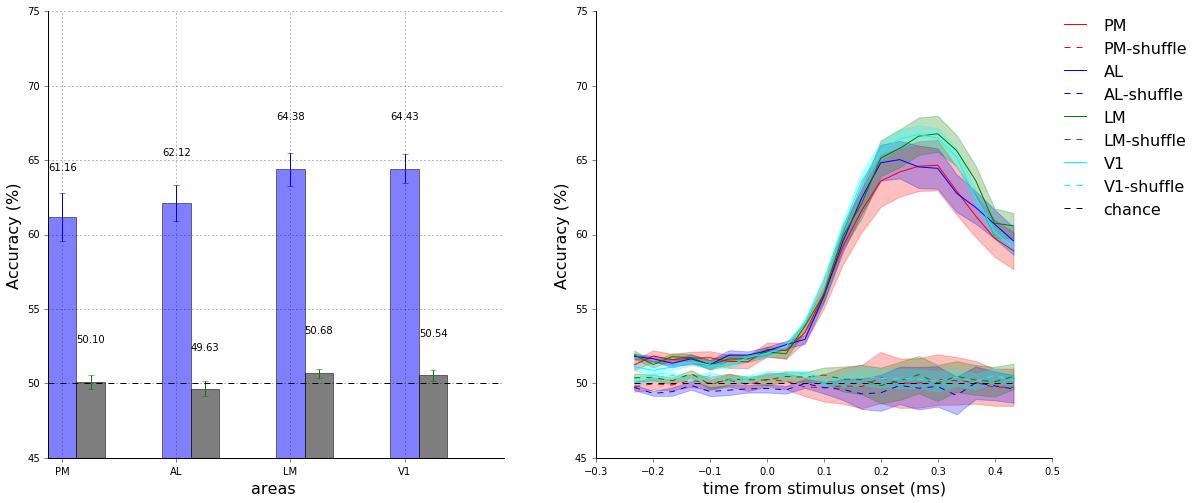

In [105]:
#make pretty plots
num_areas =len(areas)
inds =np.arange(num_areas)
chance_val = 100 /float(num_classes)
xtime = (1/float(30.1))*(np.arange(-7,14))
colors = ['red','blue','green','cyan']

fig = plt.figure(figsize=(18,8))
ax = plt.subplot(121)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')

plt.ylabel('Accuracy (%)',fontsize=16)
plt.xlabel('areas ', fontsize=16)
bar_width = 0.25

bar1 = plt.bar(inds,mean_accuracy_per_area,alpha=0.5, yerr=std_accuracy_per_area[:,0],width=bar_width)
bar2 = plt.bar(inds+bar_width,mean_accuracy_per_area_shuffle,alpha=0.5, 
yerr=std_accuracy_per_area_shuffle[:,0], width=bar_width, color='black')
chance = chance_val*np.ones(len(areas))
xs = np.linspace(0,num_areas,num=num_areas)
plt.plot(xs,chance,ls='--',color='black',label='chance')
plt.xticks(inds + 0.5 * bar_width,area_labels)
plt.grid()
ax.set_ylim(45,75)

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%0.02f' 
                %(height),ha='center', va='bottom')
autolabel(bar1)
autolabel(bar2)

ax = plt.subplot(122)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')
ax.set_ylim(45,75)

for aa in range(len(areas)):
    plt.plot(xtime,mean_accuracy_time_all[aa,:],label=area_labels[aa],color=colors[aa])
    upper = mean_accuracy_time_all[aa,:] + std_accuracy_time_all[aa,:]
    lower = mean_accuracy_time_all[aa,:] - std_accuracy_time_all[aa,:]
    plt.fill_between(xtime,lower,upper,alpha=0.25,color=colors[aa])
    
    plt.plot(xtime,mean_accuracy_time_all_shuffle[aa,:],label=area_labels[aa]+'-shuffle',
             ls='--',color=colors[aa])
    upper_shuffle = mean_accuracy_time_all_shuffle[aa,:] + std_accuracy_time_all[aa,:]
    lower_shuffle = mean_accuracy_time_all_shuffle[aa,:] - std_accuracy_time_all[aa,:]
    plt.fill_between(xtime,lower_shuffle,upper_shuffle,alpha=0.25,color=colors[aa])

plt.ylabel('Accuracy (%)',fontsize=16)
plt.xlabel('time from stimulus onset (ms)', fontsize=16)

chance = chance_val*np.ones(window_frames_to_plot)
plt.plot(xtime,chance,ls='--',color='black',label='chance')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=16)

with PdfPages('Decoder accuracy all visual areas neurons - categorization'+add_filename+'.pdf') as pdf:
    pdf.savefig(fig)

# 4. Binary classifier - per area and cell type

In [113]:
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
cre_lines = ['Cux2-CreERT2','Rorb-IRES2-Cre','Rbp4-Cre'] #layer 2/3 & 4, layer 4, layer 5
add_filename = '_all_neurons'

niter = 10 
acq_fps = float(30.1)
num_areas = len(areas)
num_cre_lines = len(cre_lines)
scale = 1
limit_neurons = 0
#intialize variables for storage
mean_accuracy_per_cre_area = np.empty([num_areas,num_cre_lines])
mean_accuracy_per_cre_area[:] = np.nan
std_accuracy_per_cre_area = np.empty([num_areas,num_cre_lines])
std_accuracy_per_cre_area[:] = np.nan
num_cells_per_cre_area = np.empty([num_areas,num_cre_lines])
num_cells_per_cre_area[:] = np.nan

mean_accuracy_time_per_cre_area = np.empty([num_cre_lines,21,num_areas]) #21 frames included
mean_accuracy_time_per_cre_area[:] = np.nan
std_accuracy_time_per_cre_area = np.empty([num_cre_lines,21,num_areas]) #21 frames included
std_accuracy_time_per_cre_area[:] = np.nan

for aa in range(num_areas):
    this_area = areas[aa]
    
    for c in range(num_cre_lines):
        this_cre = cre_lines[c]
        this_filename = this_area + '_'+ this_cre +'_sweeps_data.h5'
        with h5py.File(this_filename,'r') as hf:
            data_1 = hf.get('X_matrix_time')
            XT_ALL = np.array(data_1)
            data_2 = hf.get('Y_matrix')
            Y_ALL = np.array(data_2)
    
        y = np.median(Y_ALL,axis=0).astype(int)[50:] #select ignore first 50 trials which belong to blank
        XT_ALL = XT_ALL[50:,:,:]
        X_range = XT_ALL[:,:,stim_onset+6:stim_onset+10] #select range approximately 200 to 300ms from stimulus onset
        X_ALL = np.mean(X_range,axis=2) #compute magnitude (euclidean norm)
        
        #re-label y into category 1 (animal) or 2(non-animal)
        for cc in range(0,len(categories_values)):
            y[y==(cc+1)] = categories_values[cc]
        y_shuffle = shuffle(y)

        num_cells_per_cre_area[aa,c] = X_ALL.shape[1]
        num_neurons_include = num_cells_per_cre_area[aa,c]

        if limit_neurons:
            print('-----' + str(200) + ' neurons limit-----')
            num_neurons_include = 200
            add_filename = '_200_neurons'
            
        accuracy_per_iter = list()
        
        #run classifier 
        for ii in range(niter):
            inds = np.random.randint(0,num_neurons_include,size=num_neurons_include)
            X = X_ALL[:,inds]
            XT = XT_ALL[:,inds,:]
        
            #for cross validation do, 70/30 split. repeat 10 times and average
            X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

            if scale:
                #scale data X [0,1] - important to scale data. prevents features with high values from dominating. 
                scaler = preprocessing.MinMaxScaler()
                X_train_scale = scaler.fit_transform(X_train)
                X_test_scale = scaler.transform(X_test)
            else:
                #normalize the response of each neuron to zero mean and unit variance
                scaler = preprocessing.StandardScaler(copy=False).fit(X_train)
                X_train_scale = scaler.transform(X_train)
                X_test_scale = scaler.transform(X_test)
                
            # linear SVM classifier - to data
            linearSVM_2 = OneVsRestClassifier(LinearSVC(C=0.0163))
            linearSVM_2.fit(X_train_scale, y_train)
            accuracy_per_iter.append(100*linearSVM_2.score(X_test_scale,y_test) ) 

            # decoding accuracy across time
            time_points = XT.shape[2]
            accuracy_time = list()

            for w in range(time_points):
                X_test = XT[:,:,w]
                X_test_scale = scaler.transform(X_test)
                accuracy_time.append(100*linearSVM_2.score(X_test_scale,y))
            
            if ii == 0:
                accuracy_time_all_iter = np.array(accuracy_time)
            if ii > 0:
                accuracy_time_all_iter = np.vstack((accuracy_time_all_iter,np.array(accuracy_time)))
        
        #mean accuracy over iterations
        mean_accuracy_per_cre_area[aa,c] = np.mean(np.array(accuracy_per_iter))
        std_accuracy_per_cre_area[aa,c] = np.std(np.array(accuracy_per_iter)) / (np.sqrt(niter)) 
        
        #mean accuracy across time over iterations
        mean_accuracy_time_per_cre_area[c,:,aa] = np.mean(accuracy_time_all_iter, axis=0)
        std_accuracy_time_per_cre_area[c,:,aa] = np.std(accuracy_time_all_iter, axis=0)

        print(this_area + ', ' + this_cre + ', %d cells, Mean Test accuracy: %0.4f (+/- %0.4f)' 
              %(num_cells_per_cre_area[aa,c], mean_accuracy_per_cre_area[aa,c],std_accuracy_per_cre_area[aa,c]))

print('----Done----')


VISpm, Cux2-CreERT2, 1646 cells, Mean Test accuracy: 68.9153 (+/- 0.3226)
VISpm, Rorb-IRES2-Cre, 208 cells, Mean Test accuracy: 56.4689 (+/- 0.3905)
VISpm, Rbp4-Cre, 303 cells, Mean Test accuracy: 55.2147 (+/- 0.3425)
VISal, Cux2-CreERT2, 1380 cells, Mean Test accuracy: 66.5254 (+/- 0.4013)
VISal, Rorb-IRES2-Cre, 480 cells, Mean Test accuracy: 60.3164 (+/- 0.3990)
VISal, Rbp4-Cre, 463 cells, Mean Test accuracy: 61.8644 (+/- 0.3140)
VISl, Cux2-CreERT2, 1580 cells, Mean Test accuracy: 68.1243 (+/- 0.3108)
VISl, Rorb-IRES2-Cre, 530 cells, Mean Test accuracy: 61.2712 (+/- 0.2900)
VISl, Rbp4-Cre, 496 cells, Mean Test accuracy: 63.2712 (+/- 0.3328)
VISp, Cux2-CreERT2, 2802 cells, Mean Test accuracy: 75.4633 (+/- 0.4565)
VISp, Rorb-IRES2-Cre, 821 cells, Mean Test accuracy: 63.9379 (+/- 0.4062)
VISp, Rbp4-Cre, 566 cells, Mean Test accuracy: 62.2090 (+/- 0.3606)
----Done----


/Users/oonyekac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


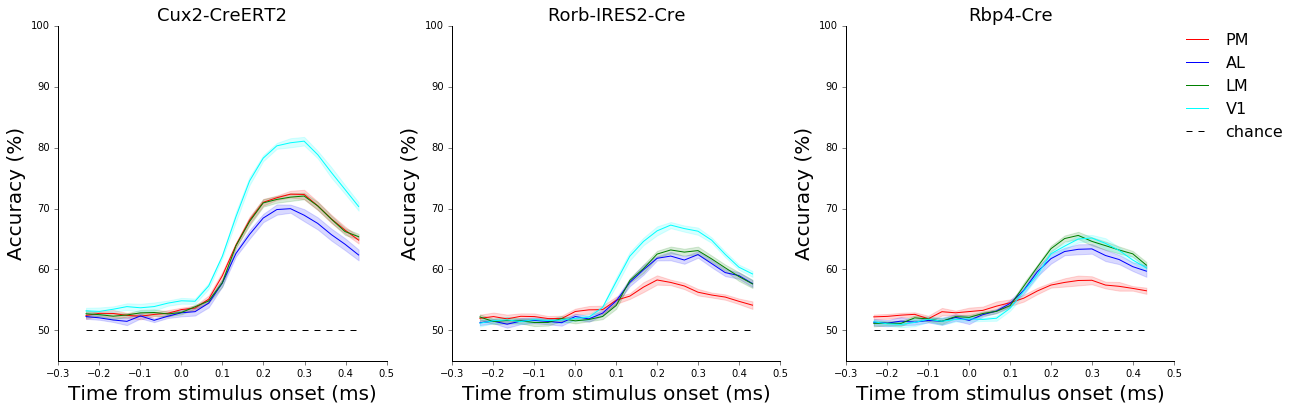

In [117]:
fig, axs = plt.subplots(1,3, figsize=(20, 6))
axs = axs.ravel()
chance = (100/float(2))*np.ones(len(xtime))
colors = ['red','blue','green','cyan']

for cc in range(num_cre_lines):
    for aa in range(num_areas):
        axs[cc].plot(xtime, mean_accuracy_time_per_cre_area[cc,:,aa], label=area_labels[aa],color=colors[aa])
        upper = mean_accuracy_time_per_cre_area[cc,:,aa] + std_accuracy_time_per_cre_area[cc,:,aa]
        lower = mean_accuracy_time_per_cre_area[cc,:,aa] - std_accuracy_time_per_cre_area[cc,:,aa]
        axs[cc].fill_between(xtime,upper,lower, alpha=0.15,color=colors[aa])
    axs[cc].plot(xtime,chance,ls='--',color='black',label='chance')

    axs[cc].spines["top"].set_visible(False)
    axs[cc].spines["right"].set_visible(False)
    axs[cc].get_xaxis().tick_bottom()
    axs[cc].get_yaxis().tick_left()
    axs[cc].tick_params(axis='both',direction='out')
    axs[cc].set_title(cre_lines[cc],fontsize=18)
    axs[cc].set_ylim(45,100)

    axs[cc].set_xlabel('Time from stimulus onset (ms)', fontsize=20)
    axs[cc].set_ylabel('Accuracy (%)', fontsize=20)

plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=16)

with PdfPages('Decoder accuracy per visual area per cell type1'+ add_filename +'-categorization.pdf') as pdf:
    pdf.savefig(fig)

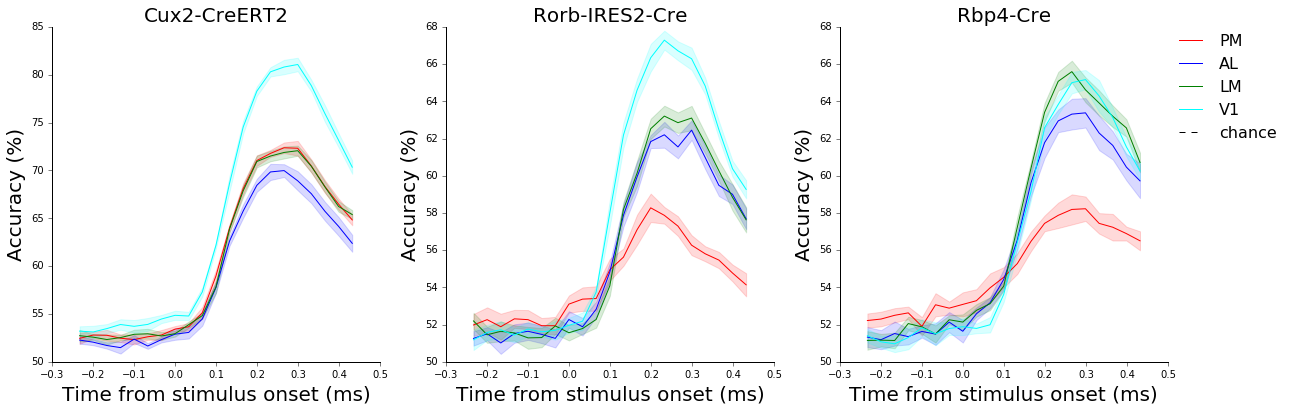

In [115]:
fig, axs = plt.subplots(1,3, figsize=(20, 6))
axs = axs.ravel()
chance = (100/float(2))*np.ones(len(xtime))
colors = ['red','blue','green','cyan']

for cc in range(num_cre_lines):
    for aa in range(num_areas):
        axs[cc].plot(xtime, mean_accuracy_time_per_cre_area[cc,:,aa], label=area_labels[aa],color=colors[aa])
        upper = mean_accuracy_time_per_cre_area[cc,:,aa] + std_accuracy_time_per_cre_area[cc,:,aa]
        lower = mean_accuracy_time_per_cre_area[cc,:,aa] - std_accuracy_time_per_cre_area[cc,:,aa]
        axs[cc].fill_between(xtime,upper,lower, alpha=0.15,color=colors[aa])
    
    axs[cc].plot(xtime,chance,ls='--',color='black',label='chance')
   
    axs[cc].spines["top"].set_visible(False)
    axs[cc].spines["right"].set_visible(False)
    axs[cc].get_xaxis().tick_bottom()
    axs[cc].get_yaxis().tick_left()
    axs[cc].tick_params(axis='both',direction='out')
    axs[cc].set_title(cre_lines[cc],fontsize=20)

    axs[cc].set_xlabel('Time from stimulus onset (ms)', fontsize=20)
    axs[cc].set_ylabel('Accuracy (%)', fontsize=20)
    
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=16)

with PdfPages('Decoder accuracy per visual area per cell type2'+add_filename+ '-categorization.pdf') as pdf:
    pdf.savefig(fig)

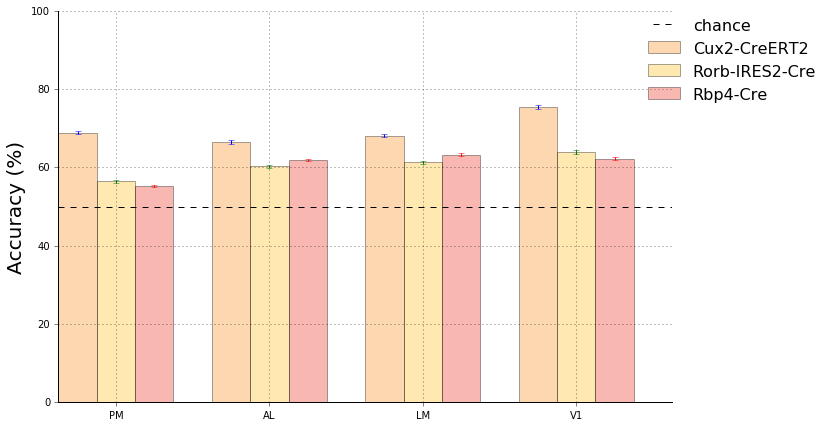

In [116]:
fig = plt.figure(figsize=(11,7))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')
#ax.set_ylim(0,50)

index = np.arange(num_areas)
bar_width = 0.25
opacity = 0.35
colors =['#F78F1E','#FFC222','#EE3224']
for cc in range(num_cre_lines):
    plt.bar(index+(cc*bar_width),mean_accuracy_per_cre_area[:,cc],width=bar_width,alpha=opacity, color=colors[cc],
            label=cre_lines[cc],yerr=std_accuracy_per_cre_area[:,cc])

ax.set_ylim(0,100)
chance = (100 * 1 /(2)) * np.ones(len(index))
xs = np.linspace(0,4,num=4)
plt.plot(xs, chance, ls='--', color='black',label='chance')
plt.ylabel('Accuracy (%)',fontsize=20)
plt.xticks(index + 1.5 * bar_width,area_labels)
plt.grid()
plt.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=16)

with PdfPages('Decoder accuracy per visual area per cell type3'+add_filename+'-categorization.pdf') as pdf:
    pdf.savefig(fig) 